In [101]:
import logging
import os
import datetime
import pandas as pd
import numpy as np
import tkinter as tk
from tkinter import filedialog
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [102]:
CO_Gray = '#404544'
CO_Orange = '#f26a3f'
CO_Blue = '#6dc4bc'
CO_Yellow = '#f9c20a'
CO_Cyan = '#005a65'
color_list = [CO_Gray, CO_Orange, CO_Blue, CO_Yellow, CO_Cyan]
#plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)

In [103]:
def init_logging():
    BASE_DIR = os.path.dirname(os.path.realpath("__file__"))
    LOG_DIR = f'{BASE_DIR}/logs/'
    if not os.path.exists(LOG_DIR):
        os.makedirs(LOG_DIR)
    today = datetime.datetime.now().strftime('%Y%m%d')
    i = 0
    while os.path.exists(f'{LOG_DIR}post_{today}_%s.log' % i):
        i += 1
    LOG_FILE = f'{LOG_DIR}post_{today}_%s.log' % i
    logging.basicConfig(filename=LOG_FILE,level=logging.DEBUG,format='%(asctime)s : %(process)d : %(levelname)s : %(message)s')
    logging.info('Logging started')
    logging.info(f'Log file saved to {LOG_FILE}') 

In [104]:
def open_data_file():
    root = tk.Tk()
    root.withdraw()
    logging.info('Prompting user to select data file')
    #return filedialog.askopenfilename()
    return 'C:/Users/noahr/Documents/GitHub/ntp/Saved_Data/trial_data_MFCC_100_162300.csv'

In [105]:
def load_data_file(f):
    df = pd.read_table(f,header=0,delimiter=',',usecols=range(12),index_col=0)
    logging.info('Converted data file to data frame')
    num_rows = len(df)
    logging.info(f'Dataframe has {num_rows} rows')
    #df = pd.Series.str.split(',', expand=True)
    return df

In [106]:
def add_elapsed_time(df):
    initial_time = df['Time'].values[0]
    elapsed_time = df['Time'].values - initial_time
    df['Elapsed Time'] = elapsed_time
    final_time = elapsed_time[-1]
    logging.info(f'Added elapsed time ({str(final_time)} seconds)')
    return df

In [107]:
def add_sfm_uncertainty(df):
    up = 0.03
    FSR = 240
    u = up*FSR
    df['SFM Uncertainty'] = np.ones(len(df))*u
    return df

In [108]:
def add_valve_delta(df):
    df['Valve Position Delta'] = df['Valve Position'].diff()
    return df

In [109]:
def add_mass_flow_error(df,target):
    df['Mass Flow Error'] = (df['Mass Flow'] - target)/target*100
    return df

In [110]:
init_logging()
f = open_data_file()
logging.info(f'Opened {f}')

df = load_data_file(f)

df = add_elapsed_time(df)

df = add_sfm_uncertainty(df)

df = add_valve_delta(df)

df = add_mass_flow_error(df,100)
df.head()

,Time,Mass Flow,Flow Temperature,Temperature 1,Internal Temperature 1,Temperature 2,Internal Temperature 2,Temperature 3,Internal Temperature 3,Pressure,Valve Position,Elapsed Time,SFM Uncertainty,Valve Position Delta,Mass Flow Error
0,1.638826e+09,155.06,24.53,0.0,0.0,0.0,0.0,0.0,0.0,0.195312,0.25,0.000000,7.2,NaN,55.06
1,1.638826e+09,155.39,24.50,0.0,0.0,0.0,0.0,0.0,0.0,0.097656,0.50,0.117837,7.2,0.25,55.39
2,1.638826e+09,155.58,24.52,0.0,0.0,0.0,0.0,0.0,0.0,0.097656,1.00,0.253991,7.2,0.50,55.58
3,1.638826e+09,154.96,24.51,0.0,0.0,0.0,0.0,0.0,0.0,0.195312,1.25,0.393128,7.2,0.25,54.96
4,1.638826e+09,155.24,24.59,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.50,0.541845,7.2,0.25,55.24


In [111]:
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticksplt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes

colors = sns.color_palette('deep')

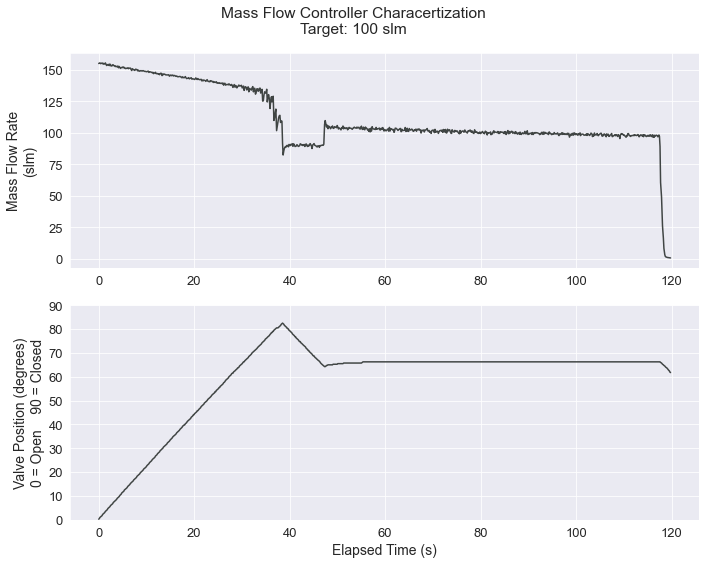

In [115]:
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(10,8),tight_layout=True)
fig.suptitle('Mass Flow Controller Characertization\nTarget: 100 slm')

sns.lineplot(ax=ax[0],x="Elapsed Time",y="Mass Flow",data = df)
ax[0].set_xlabel('')
ax[0].set_ylabel('Mass Flow Rate\n(slm)')

sns.lineplot(ax=ax[1],x="Elapsed Time",y="Valve Position",data=df)
ax[1].set_xlabel('Elapsed Time (s)')
ax[1].set_ylabel('Valve Position (degrees)\n0 = Open    90 = Closed')
ax[1].set_ylim(0,90)
ax[1].yaxis.set_major_locator(ticker.MultipleLocator(10))

plt.savefig("MFCC.svg",format="svg")

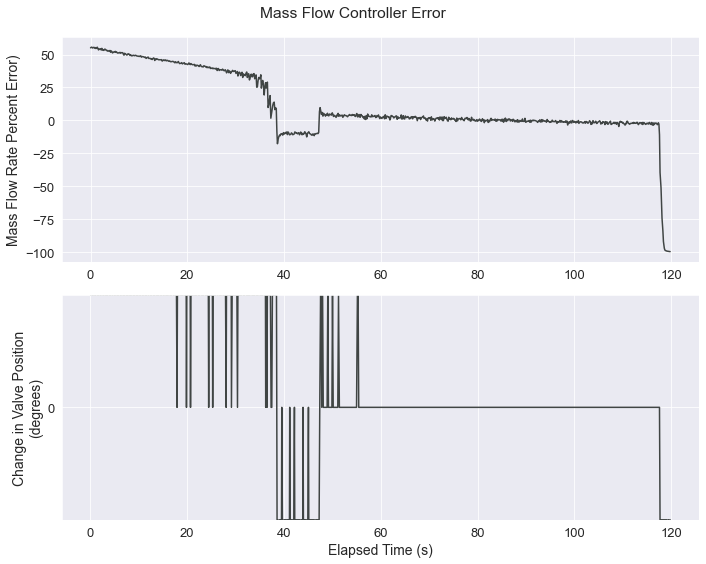

In [113]:
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(10,8),tight_layout=True)
fig.suptitle('Mass Flow Controller Error')

sns.lineplot(ax=ax[0],x="Elapsed Time",y="Mass Flow Error",data = df)
ax[0].set_xlabel('')
ax[0].set_ylabel('Mass Flow Rate Percent Error)')

sns.lineplot(ax=ax[1],x="Elapsed Time",y="Valve Position Delta",data=df)
ax[1].set_xlabel('Elapsed Time (s)')
ax[1].set_ylabel('Change in Valve Position\n(degrees)')
ax[1].set_ylim(-0.25,0.25)
ax[1].yaxis.set_major_locator(ticker.MultipleLocator(10))

plt.savefig("MFCC_delta.png")#,format="svg")